<a href="https://colab.research.google.com/github/FaizTechy/Earthquake-Prediction-using-ML-and-DL/blob/main/End_To_End_Earthquake_Magnitude_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

Earthquakes are natural phenomena that can cause significant damage and loss of life. Being able to predict their magnitude in advance can be crucial for preparedness and timely response.

The main goal of this project is to train a predictive model that can learn from the patterns of past earthquakes and make predictions about the magnitude of future earthquakes.

To achieve this goal, a combination of Deep Learning model and traditional Machine Learning model was deployed.

If an accuracy of 95% is achieved, during proof of concept. Then, this project will be followed up with live data gotten from Earthquake monitoring centers.

## Preparing the tools
The libraries used are:
* [pandas](https://pandas.pydata.org/) for data analysis.
* [NumPy](https://numpy.org/) for numerical operations.
* [Matplotlib](https://matplotlib.org/)/[seaborn](https://seaborn.pydata.org/) for plotting or data visualization.
* [Scikit-Learn](https://scikit-learn.org/stable/) for machine learning modelling and evaluation.
*   [Date-Time](https://docs.python.org/3/library/datetime.html) for manipulating dates and time.
*   [Scipy](https://docs.scipy.org/doc/scipy/tutorial/index.html#user-guide) for scientific computing.
*   [Tensorflow](https://www.tensorflow.org/) for defining and training various types  deep neural networks, CNNs, RNNs, and more.



**Importing Neccessary Dependencies**

In [127]:
!pip install tensorflow

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
import datetime
warnings.filterwarnings('ignore') # Ignore any warning messages
from scipy.stats import linregress

# Data Preprocessing and Transformation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split   #


# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError

**Data Importation and Processing**

In [129]:
Data_USGS = pd.read_csv('/content/Raw_Data_USGS.csv')

In [130]:
Data_USGS.shape

(5233, 6)

In [131]:
Data_USGS.head(2)

,time,latitude,longitude,depth,mag,Year
0,2023-03-29T21:44:21.765Z,37.7974,36.5428,5.00,4.3,2023
1,2023-03-29T20:08:37.018Z,37.3371,36.8395,4.09,4.1,2023


The **date_time** conversion of the USGS data is neccessary to make the format same withh the IRIS data before concatenation.https://docs.python.org/3/library/datetime.html

In [132]:
Data_USGS['time'] = pd.to_datetime(Data_USGS['time'])
Data_USGS['converted_time'] = Data_USGS['time'].dt.strftime('%Y-%m-%d %H:%M:%S')

# Convert the 'converted_time' column to UNIX timestamp format
# The lambda function parses the formatted string
# and converts it to seconds since the UNIX epoch
Data_USGS['Timestamp'] = Data_USGS['converted_time'].apply(lambda x: int(datetime.datetime.strptime(x, '%Y-%m-%d %H:%M:%S').strftime('%s')))

In [133]:
Data_USGS = Data_USGS.drop(['converted_time', 'time'], axis = 1)

In [134]:
Data_IRIS = pd.read_csv('/content/Raw_Data_IRIS.csv') #IRIS dataset importation

In [135]:
Data_IRIS.shape #Check the shape of the data

(1563, 6)

In [136]:
Data_USGS.head(2)

,latitude,longitude,depth,mag,Year,Timestamp
0,37.7974,36.5428,5.00,4.3,2023,1680126261
1,37.3371,36.8395,4.09,4.1,2023,1680120517


In [137]:
Data_IRIS.head(2) #Checking first two rows of IRIS dataset

,latitude,longitude,depth,mag,Timestamp,Year
0,37.7974,36.5428,5.0,4.3,1680126261,2023
1,37.3371,36.8395,4.1,4.1,1680120517,2023


***Concatenation of both the USGS and IRIS dataset since they now have the same format and shape after the initial preprocessing steps***

In [138]:
merged_data = pd.concat([Data_USGS, Data_IRIS], ignore_index=True)
merged_data = merged_data.reset_index(drop=True) # Index reset

In [139]:
merged_data.shape

(6796, 6)

In [140]:
merged_data.head(2)

,latitude,longitude,depth,mag,Year,Timestamp
0,37.7974,36.5428,5.00,4.3,2023,1680126261
1,37.3371,36.8395,4.09,4.1,2023,1680120517


In [141]:
merged_data.tail(2)

,latitude,longitude,depth,mag,Year,Timestamp
6794,38.709,33.004,33.0,4.6,1973,104718663
6795,38.934,40.653,10.0,6.9,1971,43778642


In [142]:
merged_data = merged_data.sort_values('Year', ascending=True)

In [143]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6796 entries, 5232 to 0
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   6796 non-null   float64
 1   longitude  6796 non-null   float64
 2   depth      6796 non-null   float64
 3   mag        6796 non-null   float64
 4   Year       6796 non-null   int64  
 5   Timestamp  6796 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 371.7 KB


After merging two datasets, there is need to check if seismographs from [USGS](https://www.usgs.gov/) and [IRIS](https://ds.iris.edu/ieb/index.html) have recorded the same event.

If they have, we can eliminate the duplicates.  

In [144]:
duplicate_rows = merged_data.duplicated()

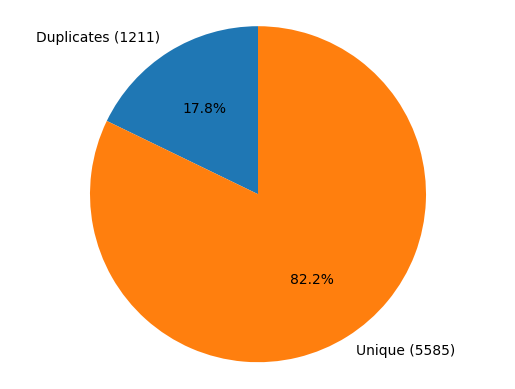

In [145]:
# Calculate the number of duplicates
num_duplicates = sum(merged_data.duplicated())
# Calculate the number of unique rows
num_unique = len(merged_data) - num_duplicates
# Create a pie chart
labels = [f'Duplicates ({num_duplicates})', f'Unique ({num_unique})']
sizes = [num_duplicates, num_unique]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')
# Show the plot
plt.show()

In [146]:
 merged_data.drop_duplicates(inplace=True) #Drop duplicate values
 merged_data.shape

(5585, 6)

**Let us confirm if we  successfully eliminated all duplicate events in the dataset.**

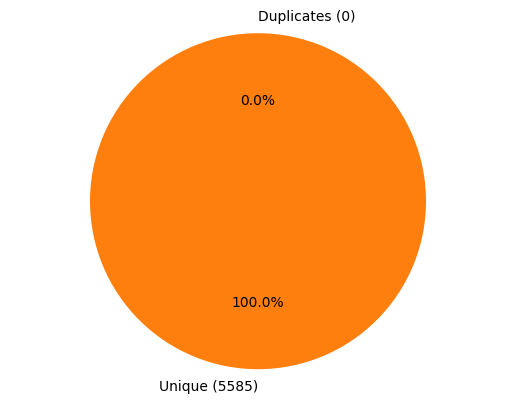

In [147]:
num_duplicates = sum(merged_data.duplicated())
num_unique = len(merged_data) - num_duplicates
labels = [f'Duplicates ({num_duplicates})', f'Unique ({num_unique})']
sizes = [num_duplicates, num_unique]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal');

In [148]:
 merged_data.describe()

,latitude,longitude,depth,mag,Year,Timestamp
count,5585.000000,5585.000000,5585.000000,5585.000000,5585.000000,5.585000e+03
mean,37.355089,33.563765,17.529567,3.961176,2001.124440,9.957266e+08
std,1.661673,3.790633,16.988957,0.714423,16.890907,5.308581e+08
min,33.950000,29.004000,0.000000,3.000000,1907.000000,-1.974907e+09
25%,36.077700,30.087000,10.000000,3.300000,1994.000000,7.597579e+08
50%,37.626000,32.329000,10.000000,4.000000,2002.000000,1.037669e+09
75%,38.590000,36.834400,22.000000,4.400000,2010.000000,1.287047e+09
max,40.447000,41.964000,159.900000,7.800000,2023.000000,1.680126e+09


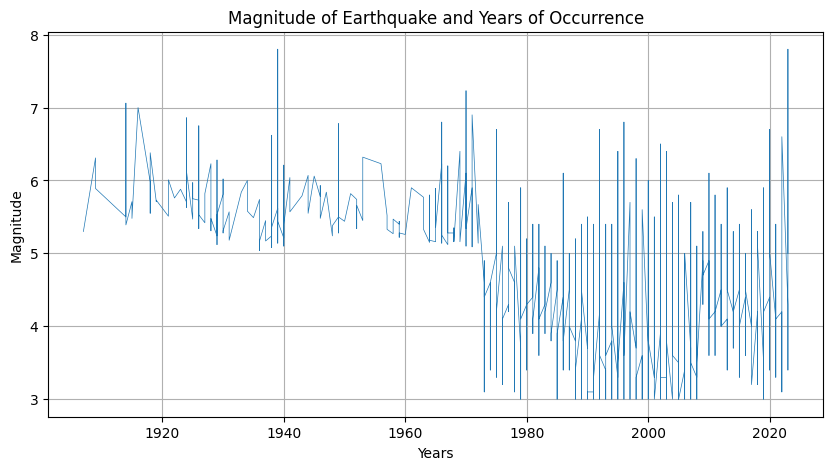

In [149]:
plt.figure(figsize = (10, 5))
years = merged_data['Year']
magnitudes = merged_data['mag']
plt.plot(years, magnitudes, linewidth=0.5)
plt.xlabel('Years')
plt.grid()
plt.ylabel('Magnitude')
plt.title('Magnitude of Earthquake and Years of Occurrence');

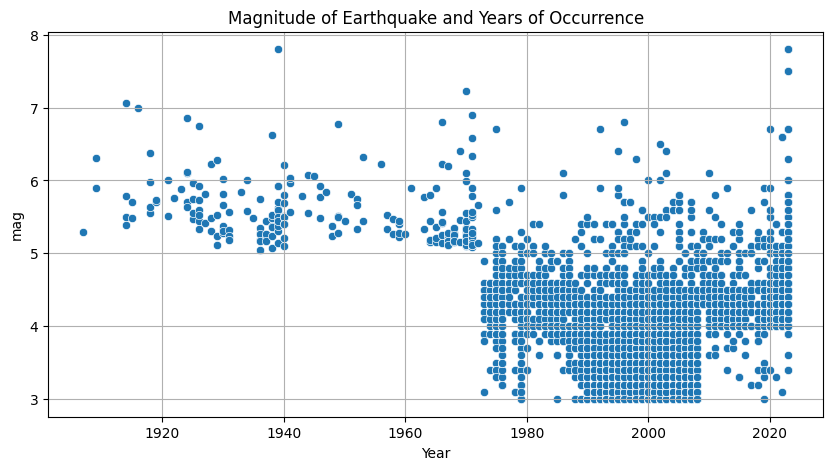

In [150]:
plt.figure(figsize=(10, 5))
sn.scatterplot(data=merged_data,
            x='Year',
            y='mag')
plt.title('Magnitude of Earthquake and Years of Occurrence')
plt.grid(True);

****The magnitude data needs to be rounded up so that the histogram will be able to capture the information.**

In [151]:
merged_data['rounded_mag'] = merged_data['mag'].round()
unique_magnitudes = np.unique(merged_data['rounded_mag'])
num_unique_magnitudes = len(unique_magnitudes)
print(f"Number of unique magnitudes: {num_unique_magnitudes}")

Number of unique magnitudes: 6


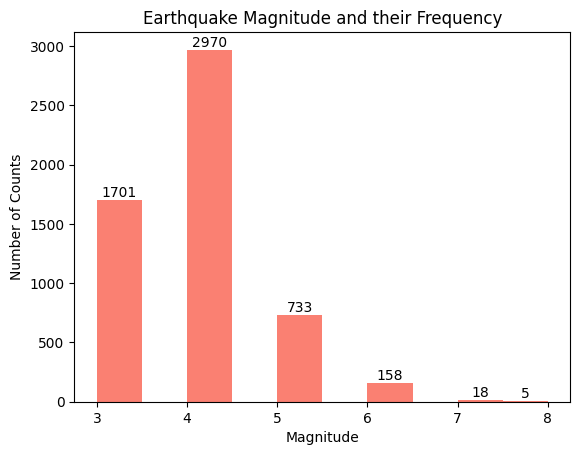

In [152]:
plt.hist(merged_data['rounded_mag'],bins = 10, color = 'salmon')
counts, edges = np.histogram(merged_data['rounded_mag'], bins=10)
for i in range(len(counts)):
    if counts[i] != 0:
        plt.text(edges[i] + (edges[i+1] - edges[i])/2, counts[i], str(counts[i]),
                 horizontalalignment='center', verticalalignment='bottom')
plt.ylabel('Number of Counts')
plt.xlabel('Magnitude')
plt.title('Earthquake Magnitude and their Frequency');

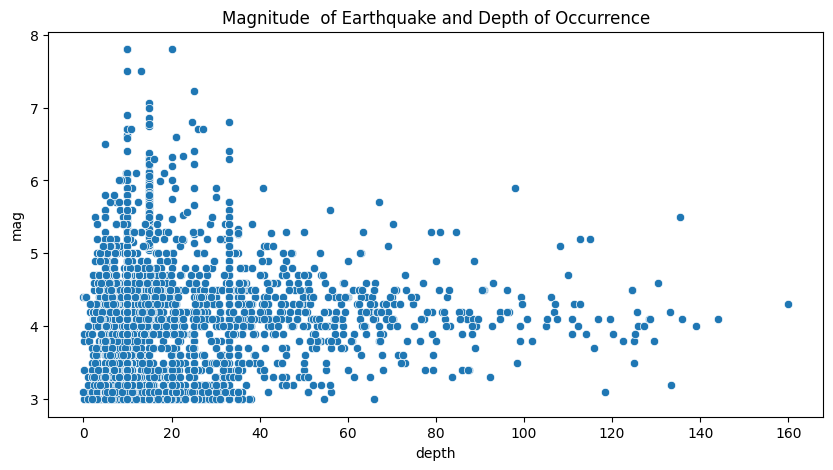

In [153]:
plt.figure(figsize=(10, 5))
sn.scatterplot(data=merged_data,
            x='depth',
            y='mag')
plt.title('Magnitude  of Earthquake and Depth of Occurrence')
plt.show()

**The relationship between the magnitude and the overall number of earthquakes in any given area and time period for a given magnitude is expressed by the Gutenberg and Richter law** https://en.wikipedia.org/wiki/Gutenberg%E2%80%93Richter_law

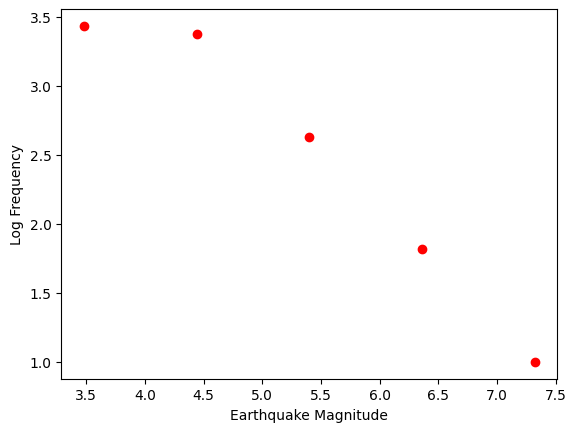

In [154]:
min_magnitude = merged_data['mag'].min()
max_magnitude = merged_data['mag'].max()
bin_edges = np.linspace(min_magnitude, max_magnitude, num=6)
bin_widths = np.diff(bin_edges)
bin_labels = range(1, len(bin_edges))
merged_data['Magnitude bin'] = pd.cut(merged_data['mag'], bins=bin_edges, labels=bin_labels, include_lowest=True)
counts = merged_data['Magnitude bin'].value_counts(sort=False)

log_counts = np.log10(counts)
bin_midpoints = bin_edges[:-1] + bin_widths / 2
plt.scatter(bin_midpoints, log_counts, color='red')
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Log Frequency');

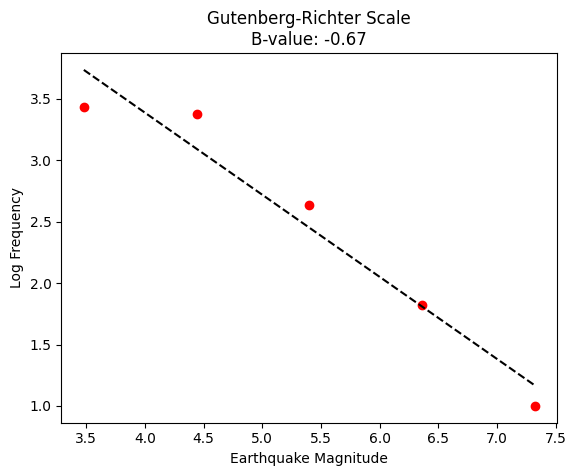

In [155]:
slope, intercept, r_value, p_value, std_err = linregress(bin_midpoints, log_counts)
# Calculate the slope and intercept using the raw x and y data
x = bin_midpoints
y = log_counts
slope, intercept, r_value, p_value, std_err = linregress(x, y)
plt.scatter(x, y, color='red')
plt.plot(x, slope*x + intercept, color='black', linestyle='--')
plt.xlabel('Earthquake Magnitude')
plt.ylabel('Log Frequency')
plt.title(f'Gutenberg-Richter Scale\nB-value: {slope:.2f}');

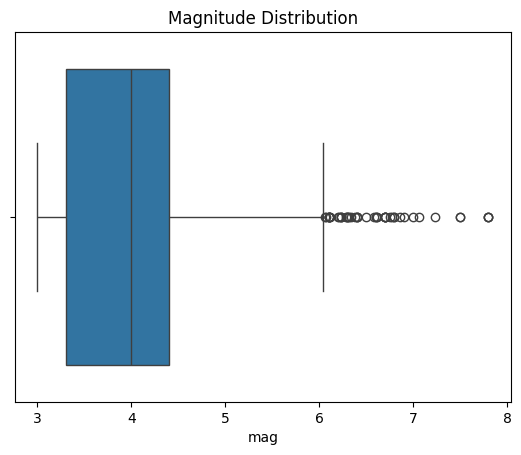

In [156]:
sn.boxplot(x=merged_data['mag'])
plt.title('Magnitude Distribution');

Visualization to see area where the most earthquake originate from within our study area.

In [157]:
merged_data['rounded_lat'] = merged_data['latitude'].round()
unique_latitude = np.unique(merged_data['rounded_lat'])
num_unique_magnitudes = len(unique_latitude)
print(f"Number of unique magnitudes: {num_unique_magnitudes}")

Number of unique magnitudes: 7


In [158]:
# Define the bin edges
min_val = merged_data['latitude'].min()
max_val = merged_data['latitude'].max()
step_size = 0.5
bin_edges = np.arange(min_val, max_val + step_size, step_size)
# Use pd.cut() to create a new column 'Latitude bin' with the bin labels
merged_data['latitude bin'] = pd.cut(merged_data['latitude'], bins=bin_edges)
# Get the frequency of each bin using value_counts()
bin_counts = merged_data['latitude bin'].value_counts(sort=False)
print(bin_counts)

latitude bin
(33.95, 34.45]    226
(34.45, 34.95]    506
(34.95, 35.45]    280
(35.45, 35.95]    271
(35.95, 36.45]    363
(36.45, 36.95]    342
(36.95, 37.45]    657
(37.45, 37.95]    597
(37.95, 38.45]    828
(38.45, 38.95]    394
(38.95, 39.45]    581
(39.45, 39.95]    307
(39.95, 40.45]    232
Name: count, dtype: int64


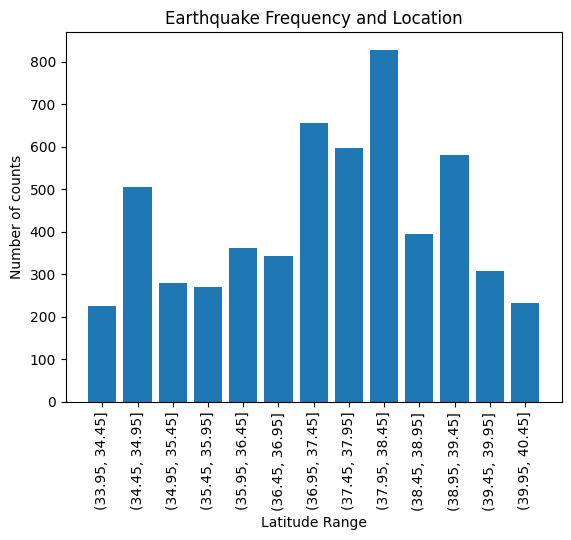

In [159]:
plt.bar(bin_counts.index.astype(str), bin_counts.values)
plt.xlabel('Latitude Range')
plt.xticks(rotation='vertical')
plt.ylabel('Number of counts')
plt.title('Earthquake Frequency and Location');

In [160]:
# Define the bin edges
min_val = merged_data['longitude'].min()
max_val = merged_data['longitude'].max()
step_size = 1
bin_edges_2 = np.arange(min_val, max_val + step_size, step_size)
# Use pd.cut() to create a new column 'Longitude bin' with the bin labels
merged_data['longitude bin'] = pd.cut(merged_data['longitude'], bins=bin_edges_2)
# Get the frequency of each bin using value_counts() and sort the ranges
bin_counts_2 = merged_data['longitude bin'].value_counts(sort=False)
# Sort the bin counts by the bin labels
bin_counts_2 = bin_counts_2.sort_index()
print(bin_counts_2)

longitude bin
(29.004, 30.004]    1328
(30.004, 31.004]     616
(31.004, 32.004]     531
(32.004, 33.004]     596
(33.004, 34.004]     351
(34.004, 35.004]      94
(35.004, 36.004]     250
(36.004, 37.004]     507
(37.004, 38.004]     341
(38.004, 39.004]     349
(39.004, 40.004]     221
(40.004, 41.004]     296
(41.004, 42.004]     103
Name: count, dtype: int64


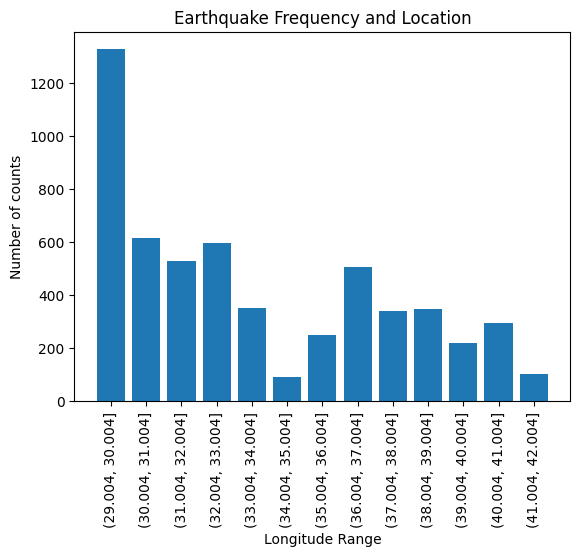

In [161]:
# plot a histogram with the counts in each bin
plt.bar(bin_counts_2.index.astype(str), bin_counts_2.values)
plt.xlabel('Longitude Range')
# rotate the x-axis labels to make them vertical
plt.xticks(rotation='vertical')
plt.ylabel('Number of counts')
plt.title('Earthquake Frequency and Location');

Displaying the subplot of all features available for exploration

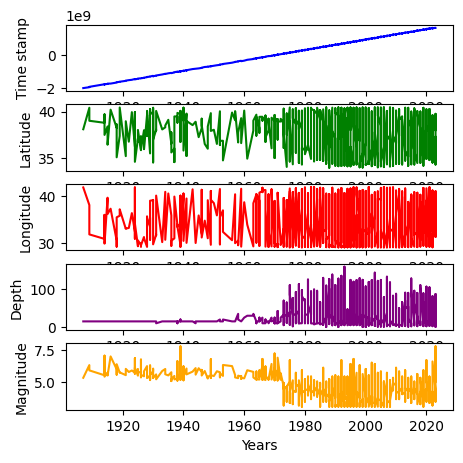

In [162]:
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(5, 5))
# Plot 1 - Timestamp vs. Year
axs[0].plot(merged_data['Year'], merged_data['Timestamp'], color='blue')
axs[0].set_ylabel('Time stamp')
# Plot 2 - Latitude vs. Year
axs[1].plot(merged_data['Year'], merged_data['latitude'], color='green')
axs[1].set_ylabel('Latitude')
# Plot 3 - Longitude vs. Year
axs[2].plot(merged_data['Year'], merged_data['longitude'], color='red')
axs[2].set_ylabel('Longitude')
# Plot 4 - Depth vs. Year
axs[3].plot(merged_data['Year'], merged_data['depth'], color='purple')
axs[3].set_ylabel('Depth')
# Plot 5 - Magnitude vs. Year
axs[4].plot(merged_data['Year'], merged_data['mag'], color='orange')
axs[4].set_ylabel('Magnitude')
axs[4].set_xlabel('Years')
# Adjust the space between the subplots
plt.subplots_adjust(hspace=0.2)
# Display the plots
plt.show()

In [163]:
merged_data.head(2)

,latitude,longitude,depth,mag,Year,Timestamp,rounded_mag,Magnitude bin,rounded_lat,latitude bin,longitude bin
5232,38.094,41.878,15.0,5.30,1907,-1974906889,5.0,3,38.0,"(37.95, 38.45]","(41.004, 42.004]"
5231,40.406,38.098,15.0,6.31,1909,-1921581355,6.0,4,40.0,"(39.95, 40.45]","(38.004, 39.004]"


The merged dataset has some features we created just to be able to explore relationship in our dataset. After the visualization stage, all these features are dropped.

In [164]:
cleaned_data = merged_data.drop(['rounded_mag', 'Magnitude bin', 'rounded_lat', 'latitude bin','longitude bin'], axis = 1)
cleaned_data.head(1)

,latitude,longitude,depth,mag,Year,Timestamp
5232,38.094,41.878,15.0,5.3,1907,-1974906889


In [165]:
# Convert the 'Timestamp' column to datetime format
cleaned_data['Timestamp'] = pd.to_datetime(cleaned_data['Timestamp'], unit='s')
# Resample the data by week and calculate the mean for each week
resampled_df= cleaned_data.resample('W', on='Timestamp').mean().reset_index().ffill() #The data was resampled by week to convert it to a time series

In [166]:
# Add a new column 'Week' to the resampled dataframe
resampled_df['Week'] = resampled_df['Timestamp'].dt.isocalendar().week

In [167]:
resampled_df = resampled_df.sort_values('Timestamp')
# Save the resampled and averaged data to a CSV file
resampled_df.to_csv('merged.csv', index=False)
# Download the CSV file from Colab
from google.colab import files
files.download('merged.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Model building**

Experimentation will be done with with two DL models (**LSTM and Bi-LSTM**) and then comparison was made with baseline traditional ML models (**Xgboost and Catboost**). This is to see which models fit the data and properly capture trends during prediction.
*   [LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) - For modeling sequential data.
*   [BI-LSTM](https://analyticsindiamag.com/complete-guide-to-bidirectional-lstm-with-python-codes/) - For modeling sequential data in both forward and backward direction.
*   [Xgboost](https://xgboost.readthedocs.io/en/stable/) - Follows principles of ensemble learning.
*   [Catboost](https://catboost.ai/) - Handling categorical features

In [168]:
!pip install catboost # Install the CatBoost library using pip

In [169]:
## reading the downloaded merged dataset
data = pd.read_csv('/content/merged.csv')

In [170]:
data.head(2)

,Timestamp,latitude,longitude,depth,mag,Year,Week
0,1907-06-09,38.094,41.878,15.0,5.3,1907.0,23
1,1907-06-16,38.094,41.878,15.0,5.3,1907.0,24


In [171]:
## checking the data datatypes
data.dtypes

Timestamp     object
latitude     float64
longitude    float64
depth        float64
mag          float64
Year         float64
Week           int64
dtype: object

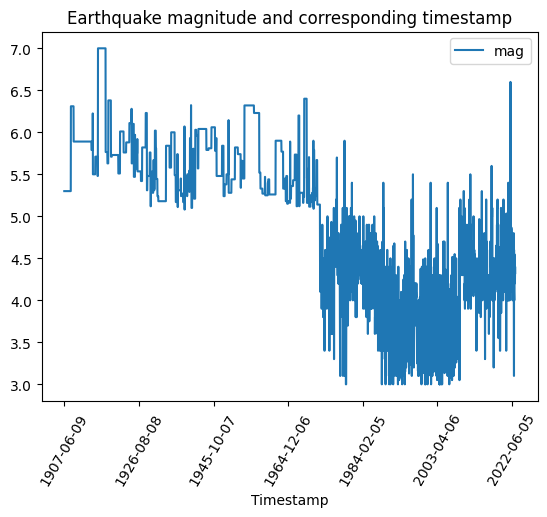

In [172]:
# create timeseries plot
data.plot(x="Timestamp", y="mag",rot = 60)
plt.title('Earthquake magnitude and corresponding timestamp');

**Observation**

From the trend, we observe that the  data is not stable from 1907 to 1975. This is due to the absence of sophisticated seismograph that can record lower magnitude earthquake before 1975. So, we dropped the observations from the data as we noticed that it was affecting the efficiency of the model.

In [173]:
#remove the data
data = data[data['Year'] > 1975].reset_index(drop=True)

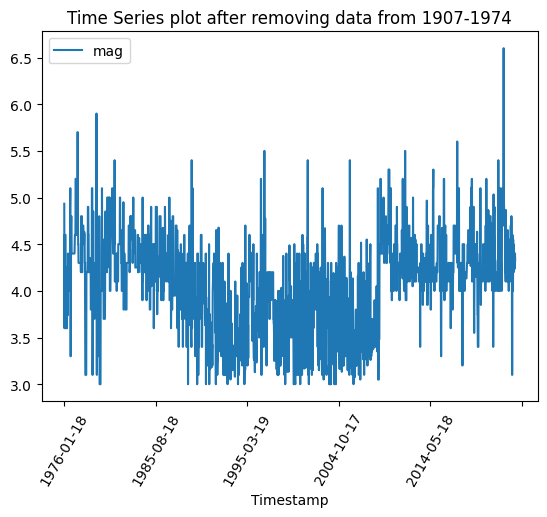

In [174]:
# create timeseries plot
data.plot(x="Timestamp", y="mag",rot = 60)
plt.title('Time Series plot after removing data from 1907-1974');

Now, the areas with anomalous earthquake events has been eliminated.

**Observation**

The trend of the plot shows the data is a time series data.

### Feature engineering

* In this we are going to extract features from the date time object.

* Add a cyclic features

Reading Aid - https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

In [175]:
data['Timestamp'] = pd.to_datetime(data['Timestamp']) # Convert the 'Timestamp' column to datetime format

In [176]:
data["month"] = data["Timestamp"].dt.month
data['day of year'] = data['Timestamp'].dt.dayofyear
data['day of month'] = data['Timestamp'].dt.day

In [177]:
data.head()

,Timestamp,latitude,longitude,depth,mag,Year,Week,month,day of year,day of month
0,1976-01-18,35.889,35.288667,35.666667,4.933333,1976.0,3,1,18,18
1,1976-01-25,34.471,32.811000,33.000000,3.600000,1976.0,4,1,25,25
2,1976-02-01,35.933,31.151000,77.000000,4.600000,1976.0,5,2,32,1
3,1976-02-08,35.933,31.151000,77.000000,4.600000,1976.0,6,2,39,8
4,1976-02-15,35.933,31.151000,77.000000,4.600000,1976.0,7,2,46,15


In [178]:
def encode(data, col, max_val):
    # Encode a cyclical feature using sine and cosine transformations
    # Create new columns with sine and cosine transformations of the feature
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)
    return data

In [179]:
# Encode the 'Year' feature using sine and cosine transformations
data = encode(data, 'Year', 4)
# Encode the 'month' feature using sine and cosine transformations
data = encode(data, 'month', 12)
# Encode the 'Week' feature using sine and cosine transformations
data = encode(data, 'Week', 7)

In [180]:
data.head()

,Timestamp,latitude,longitude,depth,mag,Year,Week,month,day of year,day of month,Year_sin,Year_cos,month_sin,month_cos,Week_sin,Week_cos
0,1976-01-18,35.889,35.288667,35.666667,4.933333,1976.0,3,1,18,18,-1.920494e-13,1.0,0.500000,0.866025,4.338837e-01,-0.900969
1,1976-01-25,34.471,32.811000,33.000000,3.600000,1976.0,4,1,25,25,-1.920494e-13,1.0,0.500000,0.866025,-4.338837e-01,-0.900969
2,1976-02-01,35.933,31.151000,77.000000,4.600000,1976.0,5,2,32,1,-1.920494e-13,1.0,0.866025,0.500000,-9.749279e-01,-0.222521
3,1976-02-08,35.933,31.151000,77.000000,4.600000,1976.0,6,2,39,8,-1.920494e-13,1.0,0.866025,0.500000,-7.818315e-01,0.623490
4,1976-02-15,35.933,31.151000,77.000000,4.600000,1976.0,7,2,46,15,-1.920494e-13,1.0,0.866025,0.500000,-2.449294e-16,1.000000


**Validation techniques**

It is important to carefully build a validation set when working on a time series problem, without destroying the sequential order within the data.

**Train data** - 1976 - 2020

**Test data** - 2021 - 2023


In [181]:
train = data[data['Year'] <= 2020].reset_index(drop=True) # train data
test = data[data['Year'] > 2020].reset_index(drop=True) # test data

In [182]:
print(train.shape)
print(test.shape)

(2346, 16)
(118, 16)


In [183]:
# drop the TimeStamp features from the data
train = train.drop('Timestamp', axis=1)
test = test.drop('Timestamp', axis=1)

In [184]:
target_col = 'mag'

In [185]:
X_train = train.drop(target_col, axis=1)
y_train = train[target_col]

# Splitting the testing data into features (X_test) and target variable (y_test)
X_test = test.drop(target_col, axis=1)
y_test = test[target_col]

**Machine Learning Model Implementation**

1. Catboost

2. Xgboost

**Baseline Models**

In [186]:
# Importing necessary libraries for regression modeling
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn import metrics

In [187]:
# Define a dictionary of regression model
class_models = {
    'catboost':{'model':CatBoostRegressor(logging_level='Silent')},
    'xgboost':{'model': XGBRegressor()}
    }

In [188]:
for model_name in class_models.keys():
    fitted_model = class_models[model_name]['model'].fit(X_train, y_train)
    y_test_pred = fitted_model.predict(X_test)
    class_models[model_name]['preds'] = y_test_pred
    class_models[model_name]['mae'] = metrics.mean_absolute_error(y_test, y_test_pred)
    class_models[model_name]['mse'] = metrics.mean_squared_error(y_test, y_test_pred)
    class_models[model_name]['rmse'] = metrics.mean_squared_error(y_test, y_test_pred, squared=False)
    metrics.mean_absolute_percentage_error(y_test, y_test_pred)
    class_models[model_name]['mape'] = metrics.mean_absolute_percentage_error(y_test, y_test_pred)

In [189]:
# Create a DataFrame from the class_models dictionary and select specific columns
class_metrics = pd.DataFrame.from_dict(class_models, 'index')[['mae', 'mse', 'rmse', 'mape']]
class_metrics

,mae,mse,rmse,mape
catboost,0.318514,0.206903,0.454866,0.071882
xgboost,0.346220,0.218213,0.467133,0.079019


### Using Deep Learning Models (LSTM and BiLSTM)

To implement a deep learning model

* The data was scaled using MinMaxScaler.

* Reshape the data to fit a deep learning model.

In [190]:
# Import necessary modules from Keras for building a neural network model
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.optimizers import Adam

In [191]:
# Import necessary modules from sklearn for data scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scale = MinMaxScaler()

In [192]:
# storing the data colum names
col_name = X_train.columns

In [193]:
## scaling the data
X_train = pd.DataFrame(scale.fit_transform(X_train), columns=col_name)
X_test = pd.DataFrame(scale.fit_transform(X_test), columns=col_name)

In [194]:
y_train.shape

(2346,)

In [195]:
X_train = np.array(X_train).reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = np.array(X_test).reshape(X_test.shape[0], 1, X_test.shape[1])

# The reshape operation converts the data into a 3-dimensional array,
# where the first dimension represents the number of samples,
# the second dimension represents the number of time steps, and
# the third dimension represents the number of features for each time step.

In [196]:
X_train.shape

(2346, 1, 14)

**Long Short Term Memory (LSTM)**

In [197]:
dropout_rate = 0.2
learning_rate = 0.01

# Create a sequential model
model = Sequential()

# Add an LSTM layer with 32 units and input shape (1, 14)
model.add(LSTM(32, input_shape=(1, 14)))

# Add a dropout layer with the specified dropout rate
model.add(Dropout(dropout_rate))

# Add a dense layer with 1 unit
model.add(Dense(1))

# Set the optimizer with the custom learning rate
optimizer = Adam(lr=learning_rate)

# Compile the model with the specified optimizer, loss function, and metrics
model.compile(optimizer='adam', loss='mae', metrics=['mse', RootMeanSquaredError(), MeanAbsolutePercentageError()])

# Print the model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 32)                6016      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6049 (23.63 KB)
Trainable params: 6049 (23.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [198]:
# fitting the Neural Network on the training data
lstm_model=model.fit(X_train,y_train,validation_data=(X_test, y_test), batch_size=32 , epochs=30, verbose=1)

Epoch 1/30
74/74 [==============================] - 7s 25ms/step - loss: 3.3000 - mse: 11.4311 - root_mean_squared_error: 3.3810 - mean_absolute_percentage_error: 81.3614 - val_loss: 2.5444 - val_mse: 6.7732 - val_root_mean_squared_error: 2.6025 - val_mean_absolute_percentage_error: 57.5880
Epoch 2/30
74/74 [==============================] - 1s 9ms/step - loss: 1.0737 - mse: 1.7320 - root_mean_squared_error: 1.3161 - mean_absolute_percentage_error: 26.2527 - val_loss: 0.6587 - val_mse: 0.6969 - val_root_mean_squared_error: 0.8348 - val_mean_absolute_percentage_error: 14.7111
Epoch 3/30
74/74 [==============================] - 1s 7ms/step - loss: 0.6298 - mse: 0.6263 - root_mean_squared_error: 0.7914 - mean_absolute_percentage_error: 15.7415 - val_loss: 0.6239 - val_mse: 0.6355 - val_root_mean_squared_error: 0.7972 - val_mean_absolute_percentage_error: 13.8840
Epoch 4/30
74/74 [==============================] - 1s 7ms/step - loss: 0.6011 - mse: 0.5748 - root_mean_squared_error: 0.7582 -

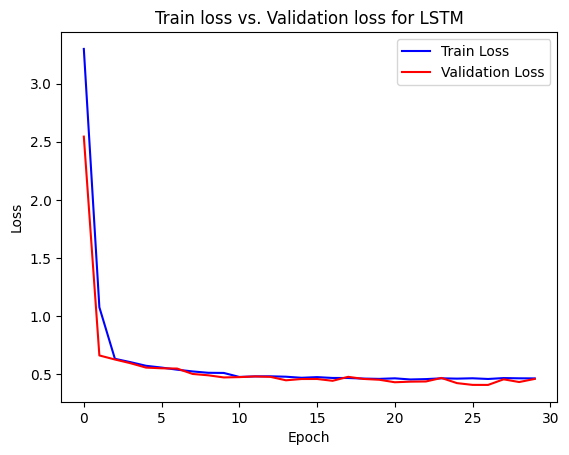

In [199]:
# Plot the training loss
plt.plot(lstm_model.history['loss'], c='b')

# Plot the validation loss
plt.plot(lstm_model.history['val_loss'], c='r')

# Set the title of the plot
plt.title('Train loss vs. Validation loss for LSTM')

# Set the label for the y-axis
plt.ylabel('Loss')

# Set the label for the x-axis
plt.xlabel('Epoch')

# Add a legend to the plot
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')

# Display the plot
plt.show()

In [200]:
# Make predictions using the model on the test data
predictions = model.predict(X_test)

4/4 [==============================] - 2s 5ms/step


In [201]:
print(mean_absolute_error(y_test, predictions))
print(mean_squared_error(y_test, predictions))
print(mean_squared_error(y_test, predictions, squared=False))
print(mean_absolute_percentage_error(y_test, predictions))

0.45645374949025264
0.3742800847617022
0.61178434497926
0.09951495032384039


**Bi - directional Long short term memory (BILSTM)**

In [202]:
import tensorflow as tf
# Set the random seed for numpy
np.random.seed(42)

# Set the random seed for tensorflow
tf.random.set_seed(56)

# Create a Sequential model
model = Sequential()

# Add a Bidirectional LSTM layer with return_sequences=True
model.add(Bidirectional(LSTM(32, return_sequences=True), input_shape=(1, 14)))

# Add a Dropout layer
model.add(Dropout(dropout_rate))

# Add another Bidirectional LSTM layer
model.add(Bidirectional(LSTM(64)))

# Add another Dropout layer
model.add(Dropout(dropout_rate))

# Add a Dense layer
model.add(Dense(1))

# Set the optimizer with a custom learning rate
optimizer = Adam(lr=learning_rate)

# Compile the model
model.compile(optimizer='adam', loss='mae', metrics=['mse', RootMeanSquaredError(), MeanAbsolutePercentageError()])

# Print the model summary
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 1, 64)             12032     
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 1, 64)             0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               66048     
 onal)                                                           
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 78209 (305.50 KB)
Trainable params: 7820

In [203]:
# fitting the Neural Network on the training data
Bilstm_model=model.fit(X_train,y_train,validation_data=(X_test, y_test), batch_size=32 , epochs=30, verbose=1)

Epoch 1/30
74/74 [==============================] - 16s 30ms/step - loss: 2.1980 - mse: 6.9705 - root_mean_squared_error: 2.6402 - mean_absolute_percentage_error: 54.2877 - val_loss: 0.7634 - val_mse: 0.9122 - val_root_mean_squared_error: 0.9551 - val_mean_absolute_percentage_error: 16.9759
Epoch 2/30
74/74 [==============================] - 1s 8ms/step - loss: 0.5892 - mse: 0.5434 - root_mean_squared_error: 0.7372 - mean_absolute_percentage_error: 14.7614 - val_loss: 0.5405 - val_mse: 0.4950 - val_root_mean_squared_error: 0.7036 - val_mean_absolute_percentage_error: 12.0067
Epoch 3/30
74/74 [==============================] - 1s 7ms/step - loss: 0.4941 - mse: 0.3824 - root_mean_squared_error: 0.6184 - mean_absolute_percentage_error: 12.4984 - val_loss: 0.4463 - val_mse: 0.3566 - val_root_mean_squared_error: 0.5971 - val_mean_absolute_percentage_error: 9.9192
Epoch 4/30
74/74 [==============================] - 1s 7ms/step - loss: 0.4651 - mse: 0.3354 - root_mean_squared_error: 0.5792 - 

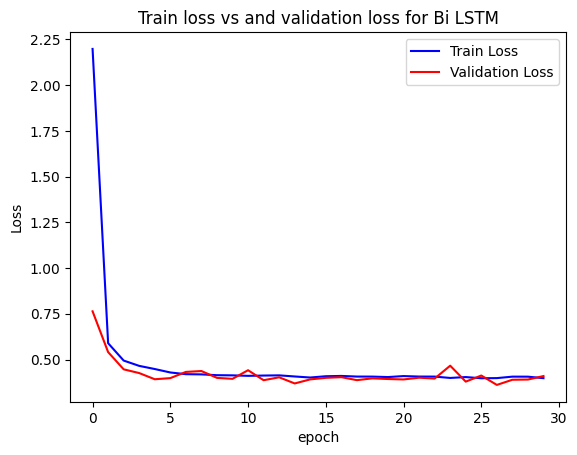

In [204]:
# Plot the training loss
plt.plot(Bilstm_model.history['loss'], c='b')

# Plot the validation loss
plt.plot(Bilstm_model.history['val_loss'], c='r')

plt.title('Train loss vs and validation loss for Bi LSTM')

plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train Loss', 'Validation Loss'], loc='upper right')

plt.show()

In [205]:
Bipredictions = model.predict(X_test)

4/4 [==============================] - 3s 5ms/step


In [206]:
print(mean_absolute_error(y_test, Bipredictions))
print(mean_squared_error(y_test, Bipredictions))
print(mean_squared_error(y_test, Bipredictions,squared=False))
print(mean_absolute_percentage_error(y_test, Bipredictions)  )

0.40951058023049713
0.30803397817790595
0.5550080883896251
0.08947565460612196


### The summary plot of model comparism across the 4 different metrics.

In [207]:
metrics = ['MAE', 'MSE', 'RMSE', 'MAPE/10']

In [208]:
xgboost_list = [mean_absolute_error(y_test, class_models['xgboost']['preds']),
mean_squared_error(y_test, class_models['xgboost']['preds']),
mean_squared_error(y_test, class_models['xgboost']['preds'],squared=False),
mean_absolute_percentage_error(y_test, class_models['xgboost']['preds'])*10]

In [209]:
# Calculate evaluation metrics for XGBoost model predictions
xgboost_list = [
    mean_absolute_error(y_test, class_models['xgboost']['preds']),
    mean_squared_error(y_test, class_models['xgboost']['preds']),
    mean_squared_error(y_test, class_models['xgboost']['preds'], squared=False),
    mean_absolute_percentage_error(y_test, class_models['xgboost']['preds']) * 10
]

In [210]:
# Calculate evaluation metrics for Catboost model predictions
catboost_list = [mean_absolute_error(y_test, class_models['catboost']['preds']),
mean_squared_error(y_test, class_models['catboost']['preds']),
mean_squared_error(y_test, class_models['catboost']['preds'],squared=False),
mean_absolute_percentage_error(y_test, class_models['catboost']['preds'])*10]

In [211]:
# Calculate evaluation metrics for lstm model predictions
lstm_list = [mean_absolute_error(y_test, predictions),
mean_squared_error(y_test, predictions),
mean_squared_error(y_test, predictions,squared=False),
mean_absolute_percentage_error(y_test, predictions)*10]

In [212]:
# Calculate evaluation metrics for BILSTM model predictions
Bilstm_list = [mean_absolute_error(y_test, Bipredictions),
 mean_squared_error(y_test, Bipredictions),
 mean_squared_error(y_test, Bipredictions,squared=False),
mean_absolute_percentage_error(y_test, Bipredictions)*10]


In [213]:
#The code turns the model evaluation results into dictionaries with metrics as keys
xgboost_dict = dict(zip(metrics, xgboost_list))
catboost_dict = dict(zip(metrics, catboost_list))
lstm_dict = dict(zip(metrics, lstm_list))
bilstm_dict = dict(zip(metrics, Bilstm_list))

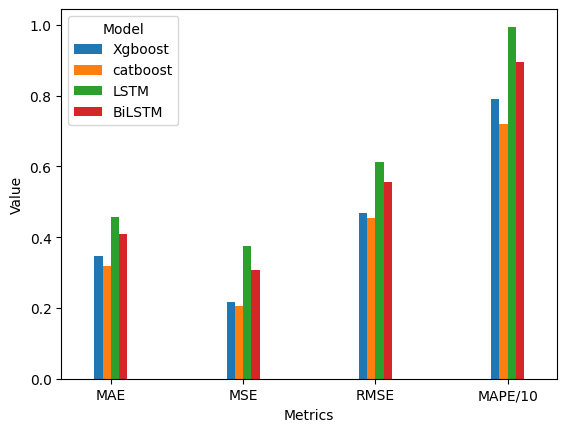

In [214]:
# Create a DataFrame from the dictionary
df = pd.DataFrame.from_dict({'Xgboost': xgboost_dict, 'catboost': catboost_dict,'LSTM': lstm_dict, 'BiLSTM': bilstm_dict})

# Plot the bar charts
ax = df.plot(kind='bar', rot=0, width=0.25)
ax.set_xlabel('Metrics')
ax.set_ylabel('Value')
ax.legend(title='Model')
plt.show()

In [215]:
df

,Xgboost,catboost,LSTM,BiLSTM
MAE,0.346220,0.318514,0.456454,0.409511
MSE,0.218213,0.206903,0.374280,0.308034
RMSE,0.467133,0.454866,0.611784,0.555008
MAPE/10,0.790194,0.718819,0.995150,0.894757


The analysis conducted highlights the better performance of
the **XGBoost method** over other approaches in the task of
time series earthquake magnitude prediction in the study
area. This can be attributed to two key factors. Firstly,
boosting methods such as Catboost and XGBoost require
less data and fewer features, making them well-suited for our
prediction problem with limited data availability. Secondly,
XGBoost incorporates a **regularization term** that controls
model complexity, preventing overfitting and improving
generalization. This balance between capturing patterns and
avoiding complexity enhances the accuracy and robustness
of earthquake magnitude predictions.

Earthquake forecasting has emerged as a crucial field for
monitoring seismic activity and providing early warnings
worldwide. In this study, we predicted the size of earthquake
events in the region of Turkey, utilizing DL and ML models
and leveraging data spanning from 1906 to 2022. Our
findings reveal that the XGBOOST model exhibits superior
forecast accuracy compared to other models. These results
underscore the significance of the XGBOOST model in
accurately predicting earthquake magnitudes in Turkey.

Accurate earthquake forecasting is crucial for minimizing
damage and saving lives. This study aimed to compare the
effectiveness of deep learning (DL) and machine learning
(ML) techniques for earthquake prediction. Integrated
approaches using Bi-directional Long Short-Term Memory
(BILSTM), Long Short-Term Memory (LSTM), Extreme
Gradient Boosting (XGBoost), and Categorical Boosting
(CatBoost) were employed to forecast earthquakes with
magnitudes equal to or exceeding 3 in Turkey. Results
showed that the machine learning algorithm XGBoost
outshone the deep learning models, indicating its superiority
in earthquake prediction for the region. XGBoost achieved
notable root mean squared error, mean absolute percentage
error, mean absolute error, and mean squared error values of
0.47, 0.079, 0.34, and 0.22 correspondingly, in forecasting
magnitudes within Turkey region